### Dataset Preparation

In [6]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("../input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24) # 비율을 나타내고 싶었던 것 같음
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


데이터셋 : 총 31개의 변수

Time : 첫번째 transaction으로부터 경과된 시간(초)
V1 ~ V28 : PCA 변환된 변수(28개)
Amount : 거래 금액
Class : Target 변수(0: 정상, 1: 비정상)

총 284,807건의 거래내역, 이 중 사기 거래(Fraud Transaction)는 492건

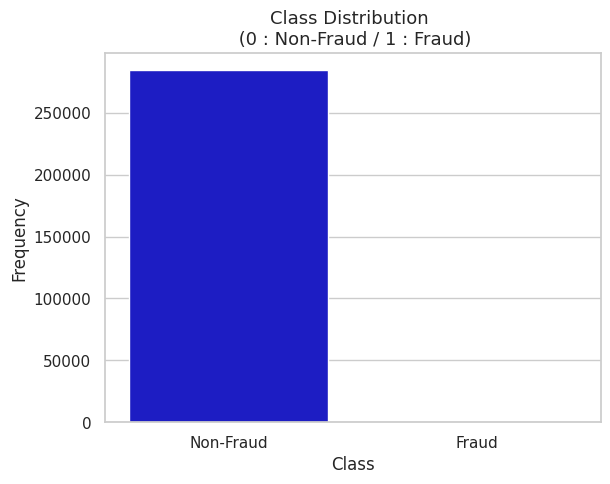

In [8]:
colors = ["#0101DF", "#DF0101"]
LABELS = ["Non-Fraud", "Fraud"]
sns.countplot(x='Class', data=data, palette=colors)

plt.title('Class Distribution \n (0 : Non-Fraud / 1 : Fraud)', fontsize=13)
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.show()

In [9]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Count,count,percent
0,0,284315,0.0
1,1,492,0.0


In [10]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,14.537951,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,5.847061,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,10.598194,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,15.010833,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,19.329722,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,23.999444,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
# non-fraud 거래내역의 1,000행만 사용

non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

X = df.drop(['Class'], axis=1).values
Y = df['Class'].values

### Visualize Fraud and Non-Fraud Transactions

이상치에 대한 기존 데이터의 패턴 파악을 위해 클러스터링을 활용한 거래의 특성 시각화.
패턴 존재 여부 파악을 위한 t-SNE 활용으로 거래의 특성 시각화
-> 2차원으로 차원 축소하여, 고차원 데이터의 시각화에 사용. 
-> 각 데이터 포인트 주변으로 유사도를 계산하여, 2차원에서 원본 특성 공간에서 데이터 클러스터링 진행 (이웃 데이터 포인트에 대한 정보 보존 최적화)

또 다른 방식, PCA (linear한 방법으로 클러스터링) : 공분산 행렬에서 고유벡터를 계산하여 진행 

### t-SNE 

In [15]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.show();

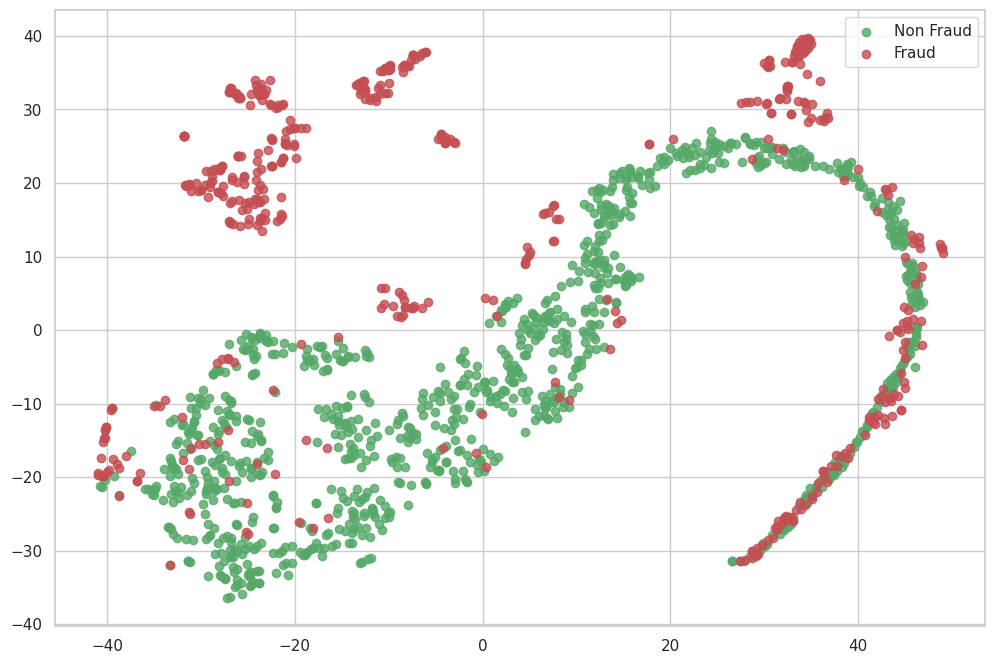

In [16]:
tsne_plot(X, Y, "original.png")

결론 : 두 거래의 뚜렷한 특징을 찾기 어려움

### Auto-encoder 

auto-encoder를 활용하여, 입력 데이터와 복원덴 데이터 사이의 차이를 계산하여 이상치 탐지 
- 가정1 : 데이터가 잘 복원될 경우, 데이터 특성 공간이 잘 파악되었다는 것이며, 데이터 특성 공간이 잘 파악되었다는 것은, 정상 관측치일 가능성이 높다.
(즉, 입력된 데이터 특성을 요약하고 복원하는 과정을 포함한 auto-encoder로 자기지도학습을 진행하여, 재구축 오차가 적은 경우를 정상 관측지 / 오차가 큰 경우 이상치 (사기 데이터셋) 로 생각)
- 가정에 대한 근거 : 사기 데이터셋이 압도적으로 적은 경우이므로, 비사기 데이터셋을 대상으로 복원 프로세스를 대부분 진행하므로 사기 데이터셋의 재구성은 학습이 거의 안되어 복원이 잘 되지 않을 것

(모든 베이스 가정 : 사기 데이터셋과 비사기 데이터셋 간 차이가 존재할 것이다 => 정규분포에서 이것이 잘 드러나면 좋겠으나 적은 데이터셋으로 인해 잘 구분되지 않는 경향성을 보완하고자 auto-encoder 방식 활용함)

In [17]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

# autoencoder 
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [18]:
# 각 변수의 범위가 다른 것을 스케일링하여 전처리 : 2,000행의 비사기 케이스만 활용하여 학습 (적은 데이터셋으로도 구분 가능)

x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [19]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], batch_size = 256, epochs = 10, shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.9134 - val_loss: 0.8095
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9130 - val_loss: 0.8089
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9123 - val_loss: 0.8082
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9110 - val_loss: 0.8076
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9102 - val_loss: 0.8069
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9098 - val_loss: 0.8062
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9093 - val_loss: 0.8056
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9079 - val_loss: 0.8049
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9076 - val_loss: 0.8042
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9066 - val_loss: 0.8035


### latent representation

In [20]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [21]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

# 입력에 대한 잠재 변수 표현. sequential layer 포함하는 네트워크를 생성해 input에 대한 예측을 통해 잠재 변수를 추출.
# 즉, fraud와 non-fraud에 대한 두 숨겨진 표현 (잠재 표현)을 생성함

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Visualize

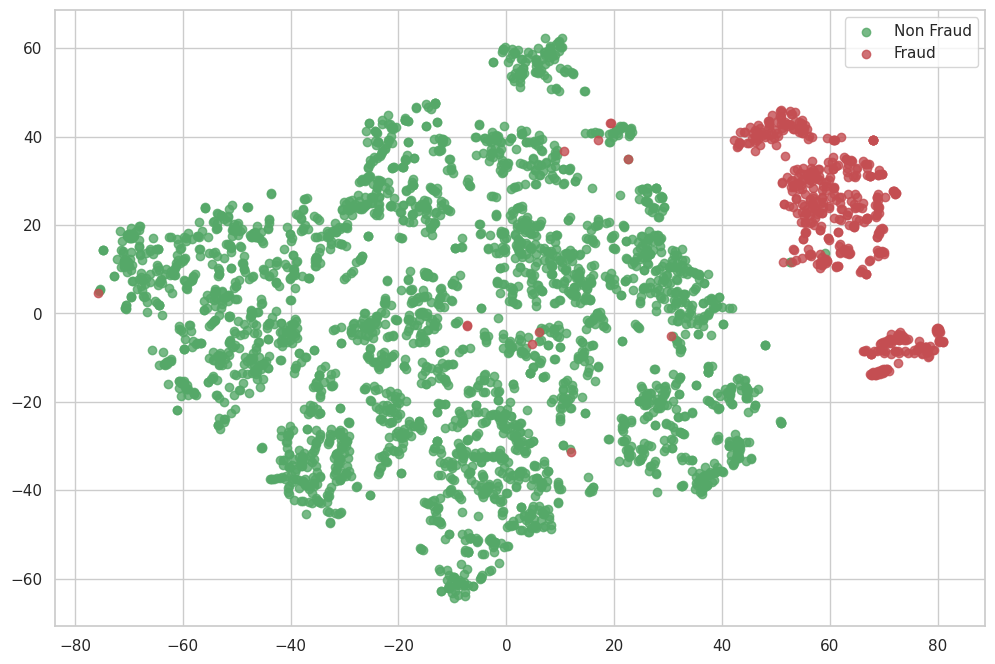

In [22]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

시각화 한 결과, 잠재변수를 활용할 경우 훨씬 classifier에 적합한 형태를 만들 수 있음을 보임.
이렇게 할 경우 간단한 linear classifier 만으로도 변별이 가능함. 

### Simple linear classifier : using Ligistic Regression

In [25]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print('Logistic Regression Accuracy Score: ', round(accuracy_score(val_y, pred_y) * 100, 3).astype(str) + '%')


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       742
         1.0       0.99      0.92      0.96       131

    accuracy                           0.99       873
   macro avg       0.99      0.96      0.97       873
weighted avg       0.99      0.99      0.99       873


Logistic Regression Accuracy Score:  98.74%


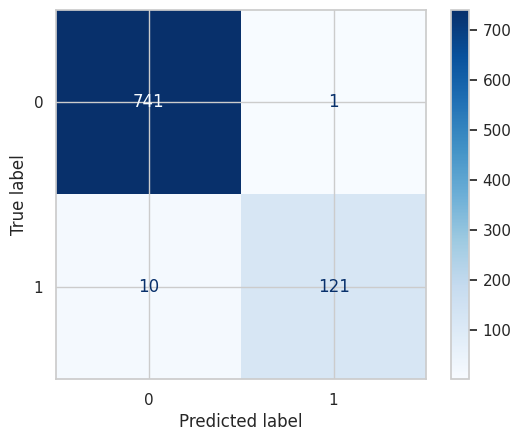

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred=pred_y, y_true=val_y)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Blues)

test 873건 (744 + 129) 
성능 : 129건의 fraud중 114건은 맞추고, 17건은 틀림

### what can i do..?

이런 식으로, 뭔가 특징이 불분명해서 내가 임의로 조작해야만 결과가 잘 나올 수 있는 사기/비사기 데이터셋에 대해,
문득 드는 생각 : 모델의 robust를 측정하기 위한 작업이 유의미한 작업인가?

- 원래 하려던 것
1. 사기 데이터셋에서 값 변형을 일부만 주어 비사기 데이터셋으로 분류하는지 확인하기 
2. 데이터셋이 없다는 가정 하에서, 그냥 랜덤한 값들을 쭉 던지며 이상치/비이상치 값을 구분하는 선형 분류 함수의 라인 찾기

추가작업 : 지도학습 말고 다른 학습 방식 없는 지 찾아보기!